In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, GeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2)
from mmfunctions.bif import (SeasonalDecompose, StateTimePreparation, AggregateKDEDensity1d)
from mmfunctions.customer import UnrollData
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)
import numpy as np
import pandas as pd
import sklearn
from sklearn.covariance import MinCovDet

In [2]:
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2021-03-04T19:46:52.043 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
###_IBM_###


In [3]:
filename = "./IOT_SHADOW_PUMP_DE_GEN5_202102231533.csv"
dff = pd.read_csv(filename, parse_dates=['EVT_TIMESTAMP'], comment='#')
dff.columns = dff.columns.str.lower()
# deal with string timestamp indices 

dff['evt_timestamp'] = pd.to_datetime(dff['evt_timestamp'], format="%Y-%m-%d-%H.%M.%S.%f")
          
df_clean = dff.drop(columns=['devicetype','logicalinterface_id','eventtype','format',
                             'rcv_timestamp_utc','updated_utc']).set_index(['deviceid','evt_timestamp'])
df_i = df_clean.dropna()

2021-03-04T19:47:04.391 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-03-04T19:47:04.391 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.


In [9]:
# hack - do not store model in db2

db.model_store = FileModelStore()

# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

sdcii = SeasonalDecompose('power', 12, np.nan, 'power_trend')
#sdcii = StateTimePreparation('power', '>4', 'power_trans')
et = sdcii._build_entity_type(columns = [Column('speed',Float())], **jobsettings)
sdcii._entity_type = et
sdcii.execute_by = ['deviceid']
df_i = sdcii.execute(df=df_i)

db.model_store = old_model_store
df_i.describe()

2021-03-04T19:19:26.049 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
2021-03-04T19:19:26.050 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-03-04T19:19:26.051 INFO mmfunctions.bif.__init__ SeasonalDecompose _init
2021-03-04T19:19:26.052 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 0.0.1
2021-03-04T19:19:26.052 DEBUG iotfunctions.util.__init__ Starting trace
2021-03-04T19:19:26.054 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_SeasonalDecompose_20210304181926
2021-03-04T19:19:26.055 DEBUG iotfunctions.util.__init__ auto_save None
2021-03-04T19:19:26.055 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-03-04T19:19:26.056 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-03-04T19:19:26.057 DEBUG iotfunctions

2021-03-04T19:20:58.797 INFO mmfunctions.bif._calc kexecute SeasonalDecompose
MultiIndex([('04714B60382B', '2021-02-16 11:15:11.088000'),
            ('04714B60382B', '2021-02-16 11:15:31.088000'),
            ('04714B60382B', '2021-02-16 11:15:51.088000'),
            ('04714B60382B', '2021-02-16 11:16:11.088000'),
            ('04714B60382B', '2021-02-16 11:16:31.088000'),
            ('04714B60382B', '2021-02-16 11:20:11.127000'),
            ('04714B60382B', '2021-02-16 11:20:31.127000'),
            ('04714B60382B', '2021-02-16 11:20:51.127000'),
            ('04714B60382B', '2021-02-16 11:21:11.127000'),
            ('04714B60382B', '2021-02-16 11:21:31.127000'),
            ...
            ('04714B60382B', '2021-02-23 11:06:41.500000'),
            ('04714B60382B', '2021-02-23 11:07:01.500000'),
            ('04714B60382B', '2021-02-23 11:07:21.500000'),
            ('04714B60382B', '2021-02-23 11:07:41.500000'),
            ('04714B60382B', '2021-02-23 11:08:01.500000'),
      

Power trend evt_timestamp
2020-12-23 22:16:11.170    0.004841
2020-12-23 22:16:31.170    0.004840
2020-12-23 22:16:51.170    0.004839
Name: power, dtype: float64
Power trend deviceid      evt_timestamp          
04714B606390  2020-12-23 22:16:11.170    0.004841
              2020-12-23 22:16:31.170    0.004840
              2020-12-23 22:16:51.170    0.004839
Name: power_trend, dtype: float64
2021-03-04T19:21:41.375 INFO mmfunctions.bif._calc Exit SeasonalDecompose


NameError: name 'old_model_store' is not defined

In [ ]:
df_i

deviceid
04714B601096    AxesSubplot(0.125,0.125;0.775x0.755)
04714B603408    AxesSubplot(0.125,0.125;0.775x0.755)
04714B6036B1    AxesSubplot(0.125,0.125;0.775x0.755)
04714B6037F8    AxesSubplot(0.125,0.125;0.775x0.755)
04714B60382B    AxesSubplot(0.125,0.125;0.775x0.755)
04714B604101    AxesSubplot(0.125,0.125;0.775x0.755)
04714B60553A    AxesSubplot(0.125,0.125;0.775x0.755)
04714B605699    AxesSubplot(0.125,0.125;0.775x0.755)
04714B606390    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

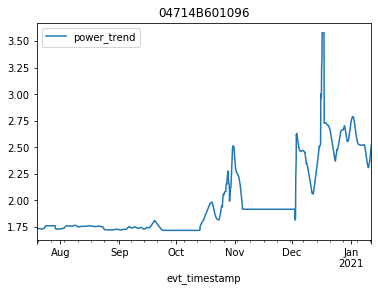

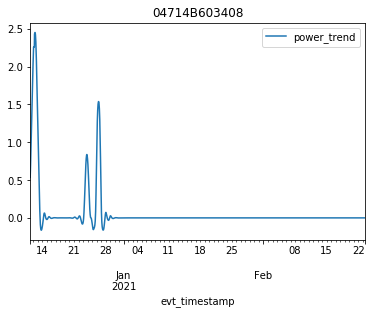

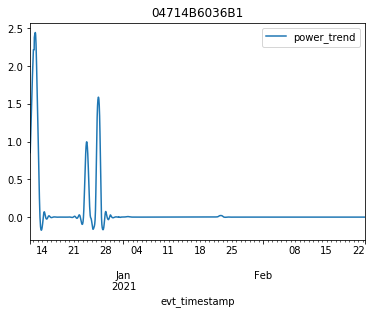

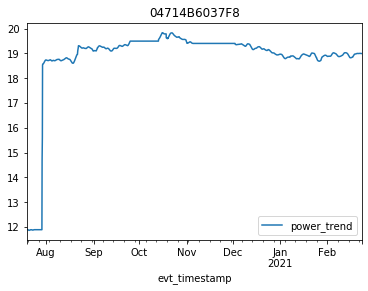

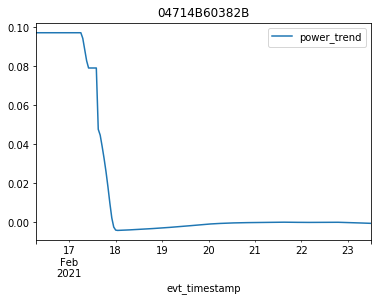

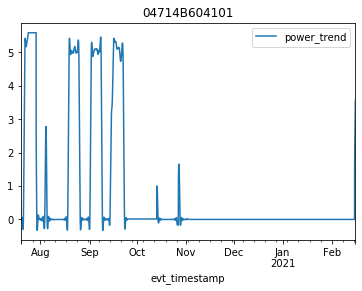

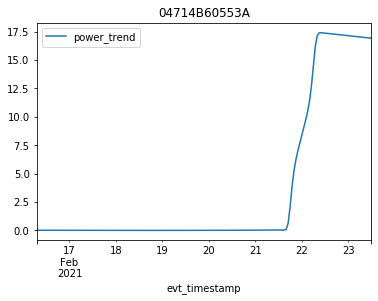

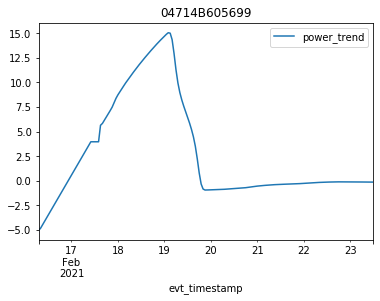

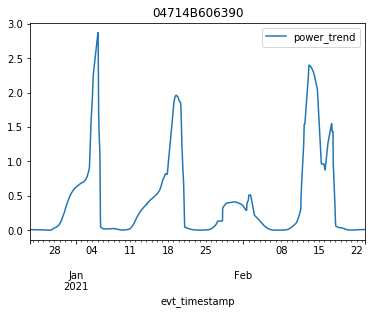

In [11]:
df_i[['power_trend']].groupby(['deviceid']).apply(lambda group:
    group.reset_index(level=0).resample('H').mean().ffill().plot(title=group.index[0][0]))



### Compute daily outliers 
based on KDE density 

In [4]:
from iotfunctions.base import BaseSimpleAggregator
from iotfunctions.aggregate import (Aggregation, AggregateWithCalculation, add_simple_aggregator_execute)

# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.DEBUG)

func = AggregateKDEDensity1d

# prepare parameter list
params_dict = {}
params_dict['source'] = 'power'
params_dict['name'] = 'power_out'
params_dict['alpha'] = 0.995

# replace aggregate call with 'execute_AggregateWithExpression'
func_name = 'execute_AggregateTimeInState'
add_simple_aggregator_execute(func, func_name)

func_clos = getattr(func(**params_dict), func_name)


# set up an Aggregation thingy with the entity index, timestamp index, 
# desired granularity and a (short) chain of aggregators
# granularity = frequency, dimension(s), include entity, entity id
aggii = Aggregation(None, ids=['deviceid'], timestamp='evt_timestamp', granularity=('D', None, True, 0), 
                    simple_aggregators=[(['power'], func_clos, 0.995)])
print(aggii)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = aggii._build_entity_type(columns = [Column('changed',Float())], **jobsettings)

t = aggii.execute(df=df_i)


2021-03-04T19:47:04.428 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-03-04T19:47:04.430 INFO mmfunctions.bif.__init__ AggregateKDEDensity1d _init
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abort_on_fail', '_add_explicit_outputs', '_allow_empty_df', '_build_entity_type', '_calc', '_coallesce_columns', '_end_date', '_entity_scd_dict', '_entity_type', '_getJsonDataType', '_getJsonSchema', '_getMetadata', '_get_arg_metadata', '_get_data_scope', '_get_scd_history', '_get_series', '_inferOutputs', '_infer_array_source', '_infer_type', '_input_set', '_inputs', '_is_instance_level_logged', '_metadata_params', '_output_items_extended_

1.8514
2021-03-04T19:47:05.647 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 1.773
2021-03-04T19:47:05.647 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:05.736 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1439 inliers: 1 outliers: 1
1.8032
2021-03-04T19:47:05.736 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 1.7462
2021-03-04T19:47:05.737 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:05.821 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1427 inliers: 1 outliers: 1
1.82
2021-03-04T19:47:05.822 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 1.7432
2021-03-04T19:47:05.823 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:05.909 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1439 inliers: 1 outliers: 1
1.8152
2021-03-04T19:47:05.910 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 1.7626
2021-03-04T19:47:05.910 INFO mmfunct

2021-03-04T19:47:08.146 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:08.237 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
1.7552
2021-03-04T19:47:08.238 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 1.7232
2021-03-04T19:47:08.239 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:08.328 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
1.8072
2021-03-04T19:47:08.329 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 1.7134
2021-03-04T19:47:08.329 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:08.416 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
1.7608
2021-03-04T19:47:08.417 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 1.716
2021-03-04T19:47:08.417 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:08.504 INFO mmfunctions.bif.exe

2021-03-04T19:47:10.462 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:10.549 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1438 inliers: 1 outliers: 1
2.0952
2021-03-04T19:47:10.549 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 1.866
2021-03-04T19:47:10.550 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:10.635 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1427 inliers: 1 outliers: 1
2.1156
2021-03-04T19:47:10.635 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 1.9268
2021-03-04T19:47:10.635 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:10.720 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
2.2274
2021-03-04T19:47:10.721 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 1.7764
2021-03-04T19:47:10.722 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:10.805 INFO mmfunctions.bif.exe

2021-03-04T19:47:12.759 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:12.844 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1417 inliers: 1 outliers: 1
2.9202
2021-03-04T19:47:12.844 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 2.1966
2021-03-04T19:47:12.845 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:12.890 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1085 inliers: 1 outliers: 1
2.6108
2021-03-04T19:47:12.891 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 2.087
2021-03-04T19:47:12.891 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:12.949 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1240 inliers: 1 outliers: 1
2.6698
2021-03-04T19:47:12.950 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 2.149
2021-03-04T19:47:12.950 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:13.035 INFO mmfunctions.bif.exec

2021-03-04T19:47:15.021 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:15.126 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1434 inliers: 1 outliers: 1
3.151
2021-03-04T19:47:15.127 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 2.5042
2021-03-04T19:47:15.127 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:15.211 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1426 inliers: 1 outliers: 1
3.1838
2021-03-04T19:47:15.212 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 2.3664
2021-03-04T19:47:15.212 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:15.296 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1430 inliers: 1 outliers: 1
2.856
2021-03-04T19:47:15.297 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 2.3456
2021-03-04T19:47:15.297 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:15.382 INFO mmfunctions.bif.exec

2021-03-04T19:47:15.892 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1430 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:15.893 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:15.893 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:15.893 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:15.896 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:15.897 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:15.898 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:15.898 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:15.902 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-

2021-03-04T19:47:15.985 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:15.988 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:15.989 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:15.989 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:15.989 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:15.993 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:15.994 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:15.994 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:15.995 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:15.999 INFO mmfunction

2021-03-04T19:47:16.091 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:16.091 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:16.095 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1439 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:16.096 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:16.096 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:16.097 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:16.102 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1435 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:16.102 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:16.103 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:16.103 INFO mmfuncti

2021-03-04T19:47:16.190 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:16.190 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:16.192 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 735 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:16.193 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:16.193 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:16.193 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:16.233 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 900 inliers: 1 outliers: 1
8.173201
2021-03-04T19:47:16.234 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:16.234 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:16.235 INFO mmfun

2021-03-04T19:47:16.668 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:16.671 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:16.671 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:16.671 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:16.672 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:16.674 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:16.675 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:16.675 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:16.675 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:16.679 INFO mmfunction

2021-03-04T19:47:16.759 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:16.759 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:16.762 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:16.763 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:16.763 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:16.764 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:16.767 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1425 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:16.768 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:16.769 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:16.769 INFO mmfuncti

2021-03-04T19:47:17.010 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1435 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:17.010 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:17.011 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:17.011 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:17.015 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:17.016 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:17.016 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:17.016 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:17.019 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-

2021-03-04T19:47:17.128 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:17.220 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
12.0626
2021-03-04T19:47:17.221 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 11.8758
2021-03-04T19:47:17.221 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:17.309 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1431 inliers: 1 outliers: 1
12.070399
2021-03-04T19:47:17.310 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 11.8552
2021-03-04T19:47:17.310 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:17.407 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
12.0834
2021-03-04T19:47:17.407 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:17.407 INFO mmfunctions.bif.execute Agg

2021-03-04T19:47:18.981 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:19.069 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
19.067999
2021-03-04T19:47:19.069 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 18.662201
2021-03-04T19:47:19.070 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:19.155 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1435 inliers: 1 outliers: 1
19.043201
2021-03-04T19:47:19.156 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 18.795399
2021-03-04T19:47:19.156 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:19.243 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
19.049999
2021-03-04T19:47:19.244 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:19.244 INFO mmfunctions.bif.exe

2021-03-04T19:47:21.074 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1430 inliers: 1 outliers: 1
19.5012
2021-03-04T19:47:21.074 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 19.266399
2021-03-04T19:47:21.075 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:21.162 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1439 inliers: 1 outliers: 1
19.4758
2021-03-04T19:47:21.163 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 19.1912
2021-03-04T19:47:21.163 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:21.256 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
19.463001
2021-03-04T19:47:21.257 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 19.050602
2021-03-04T19:47:21.257 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:21.349 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1437 inliers: 1 outliers: 1
19.4832


2021-03-04T19:47:22.979 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
19.908001
2021-03-04T19:47:22.980 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 19.461
2021-03-04T19:47:22.980 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:23.069 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1430 inliers: 1 outliers: 1
19.975599
2021-03-04T19:47:23.070 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 19.6108
2021-03-04T19:47:23.070 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:23.160 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
20.149401
2021-03-04T19:47:23.160 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:23.161 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:23.161 INFO mmfunctions.bif.execut

19.668402
2021-03-04T19:47:24.789 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 19.281399
2021-03-04T19:47:24.789 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:24.872 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1388 inliers: 1 outliers: 1
19.630001
2021-03-04T19:47:24.873 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 19.259199
2021-03-04T19:47:24.873 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:24.962 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1432 inliers: 1 outliers: 1
19.59
2021-03-04T19:47:24.963 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:24.963 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:24.964 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:25.057 INFO mmfunctions.bif.execute AggregateKDEDensity1d: s

19.232601
2021-03-04T19:47:26.827 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 18.936199
2021-03-04T19:47:26.827 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:26.910 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
19.240799
2021-03-04T19:47:26.911 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 18.785
2021-03-04T19:47:26.911 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:26.995 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
19.1684
2021-03-04T19:47:26.996 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:26.996 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:26.997 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:27.080 INFO mmfunctions.bif.execute AggregateKDEDensity1d: si

2021-03-04T19:47:28.734 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:28.816 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1425 inliers: 1 outliers: 1
19.2234
2021-03-04T19:47:28.816 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 18.935001
2021-03-04T19:47:28.817 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:28.900 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
19.126999
2021-03-04T19:47:28.900 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 18.991598
2021-03-04T19:47:28.901 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:28.986 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1430 inliers: 1 outliers: 1
19.079599
2021-03-04T19:47:28.986 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:28.987 INFO mmfunctions.bif.execu

2021-03-04T19:47:30.660 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
19.222
2021-03-04T19:47:30.661 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 19.1078
2021-03-04T19:47:30.662 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:30.747 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1430 inliers: 1 outliers: 1
19.0926
2021-03-04T19:47:30.749 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:30.749 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:30.749 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:30.834 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1425 inliers: 1 outliers: 1
19.082001
2021-03-04T19:47:30.836 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has n

2021-03-04T19:47:31.478 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1434 inliers: 1 outliers: 1
5.5682
2021-03-04T19:47:31.479 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:31.479 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:31.480 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:31.566 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1439 inliers: 1 outliers: 1
5.8052
2021-03-04T19:47:31.566 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:31.566 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:31.567 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:31.651 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1435 inliers: 1 outliers: 1
5.9047

2021-03-04T19:47:31.877 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:31.878 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:31.881 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:31.882 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:31.882 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:31.882 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:31.885 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:31.886 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:31.886 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:31.886 INFO mmfuncti

5.9832
2021-03-04T19:47:32.713 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:32.713 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:32.714 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:32.800 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
6.2508
2021-03-04T19:47:32.801 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:32.801 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:32.801 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:32.886 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
6.2338
2021-03-04T19:47:32.887 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to re

6.4386
2021-03-04T19:47:33.930 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:33.931 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:33.931 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:34.014 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
6.503
2021-03-04T19:47:34.014 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:34.015 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:34.015 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:34.098 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
6.1022
2021-03-04T19:47:34.098 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 5.3368
2021-03-04T19:47:34.

2021-03-04T19:47:34.178 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:34.179 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:34.228 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1115 inliers: 1 outliers: 1
3.6424
2021-03-04T19:47:34.229 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:34.229 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:34.230 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:34.232 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:34.233 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:34.233 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:34.234 INFO mmfun

2021-03-04T19:47:34.615 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:34.673 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1426 inliers: 1 outliers: 1
16.291
2021-03-04T19:47:34.673 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 15.0006
2021-03-04T19:47:34.674 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:34.740 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1431 inliers: 1 outliers: 1
43.012794
2021-03-04T19:47:34.740 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:34.740 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:34.741 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:34.744 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1435 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:34.744 INFO mmfunctions.bif.execute Establishing t

2021-03-04T19:47:35.942 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:35.942 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0.0
2021-03-04T19:47:35.943 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:36.020 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1425 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:36.020 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0.0
2021-03-04T19:47:36.020 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:36.098 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1430 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:36.098 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0.0
2021-03-04T19:47:36.099 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:36.181 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1440 inliers: 1 outliers: 1
2.3502
2021-03-04T19:47:36.182 INFO mm

2021-03-04T19:47:37.508 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1418 inliers: 1 outliers: 1
2.251
2021-03-04T19:47:37.509 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0.0
2021-03-04T19:47:37.509 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:37.590 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1429 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:37.590 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0.0
2021-03-04T19:47:37.591 INFO mmfunctions.bif.execute Execute AggregateKDEDensity1d
2021-03-04T19:47:37.593 INFO mmfunctions.bif.execute AggregateKDEDensity1d: size: 1435 inliers: 1 outliers: 1
0.0
2021-03-04T19:47:37.594 INFO mmfunctions.bif.execute Establishing threshold failed with zero-size array to reduction operation minimum which has no identity
2021-03-04T19:47:37.594 INFO mmfunctions.bif.execute AggregateKDEDensity1d returns 0
2021-03-04T19:47:37.594 INFO mmfunctions.bif.execute Execute AggregateKDED

2021-03-04T19:47:38.534 DEBUG iotfunctions.util.log_data_frame aggregation_final_df = (5, 1) 
+----------------------------------------------------+---------+
|                                                    |   0.995 |
|----------------------------------------------------+---------|
| ('04714B601096', Timestamp('2020-07-19 00:00:00')) |  1.727  |
| ('04714B601096', Timestamp('2020-07-20 00:00:00')) |  1.7288 |
| ('04714B601096', Timestamp('2020-07-21 00:00:00')) |  1.74   |
| ('04714B601096', Timestamp('2020-07-22 00:00:00')) |  1.7258 |
| ('04714B601096', Timestamp('2020-07-23 00:00:00')) |  1.7288 |
+----------------------------------------------------+---------+


In [12]:
t[0.995]

deviceid      evt_timestamp
04714B601096  2020-07-19       1.7270
              2020-07-20       1.7288
              2020-07-21       1.7400
              2020-07-22       1.7258
              2020-07-23       1.7288
                                ...  
04714B606390  2021-02-19       0.0000
              2021-02-20       0.0000
              2021-02-21       0.0000
              2021-02-22       0.0000
              2021-02-23       0.0000
Name: 0.995, Length: 626, dtype: float64

deviceid
04714B601096    AxesSubplot(0.125,0.125;0.775x0.755)
04714B603408    AxesSubplot(0.125,0.125;0.775x0.755)
04714B6036B1    AxesSubplot(0.125,0.125;0.775x0.755)
04714B6037F8    AxesSubplot(0.125,0.125;0.775x0.755)
04714B60382B    AxesSubplot(0.125,0.125;0.775x0.755)
04714B604101    AxesSubplot(0.125,0.125;0.775x0.755)
04714B60553A    AxesSubplot(0.125,0.125;0.775x0.755)
04714B605699    AxesSubplot(0.125,0.125;0.775x0.755)
04714B606390    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

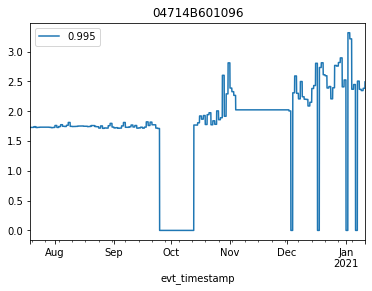

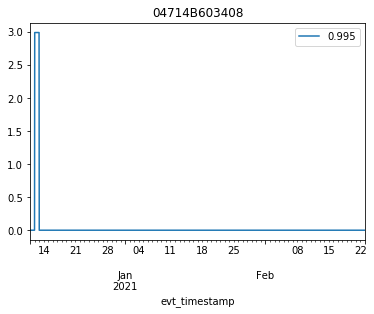

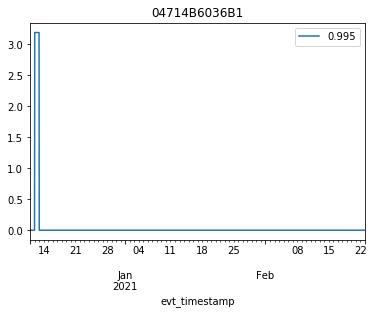

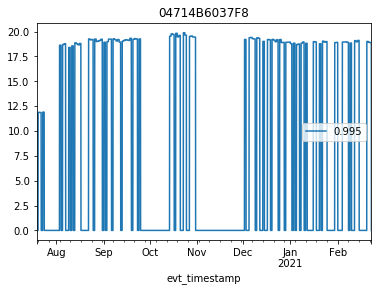

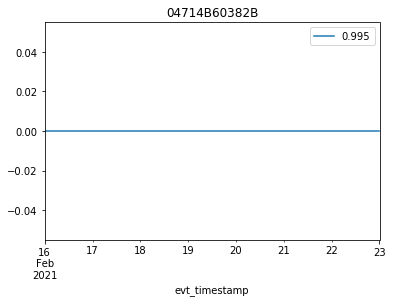

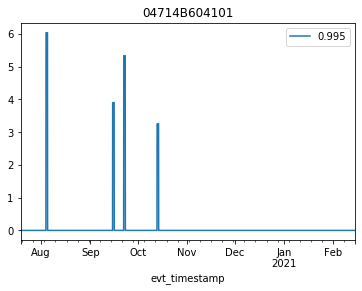

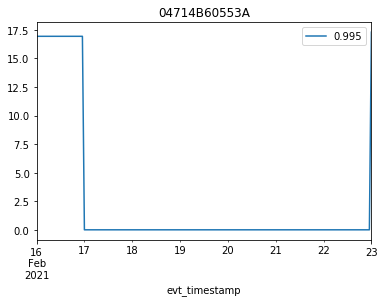

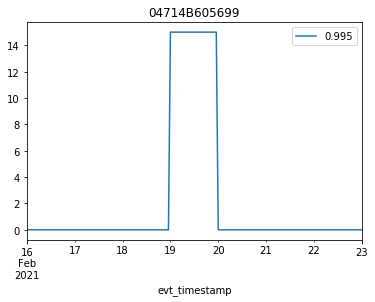

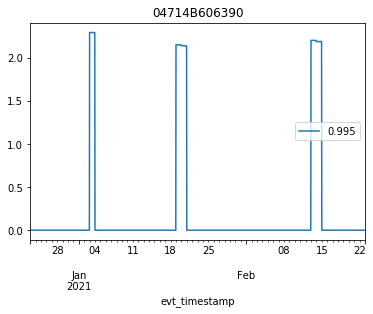

In [14]:
t[[0.995]].groupby(['deviceid']).apply(lambda group:
    group.reset_index(level=0).resample('H').mean().ffill().plot(title=group.index[0][0]))